<a href="https://colab.research.google.com/github/rpasquini/metodos_cuantitativos/blob/main/Geocodificacion_terrenos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install geocoder

In [4]:
!pip install geopandas

In [36]:
import pandas as pd
import geopandas as gpd
import geocoder

In [9]:
terrenos=pd.read_excel("/content/Terrenos-en-venta-2020 (1).xlsx")

In [10]:
terrenos

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5
...,...,...,...,...,...,...,...,...,...,...
10296,"BONORINO, ESTEBAN, Cnel. 300",149,430000,27412500,2886,183976,64,PRIMER,FLORES NORTE,7
10297,RIVERA INDARTE 100,500,790000,50362500,1580,100725,64,PRIMER,FLORES NORTE,7
10298,"ALVAREZ, DONATO, Tte. Gral. 200",771,690000,43987500,895,57052,64,PRIMER,FLORES NORTE,7
10299,"ALBERDI, JUAN BAUTISTA 3100",409,800000,51000000,1956,124694,64,PRIMER,FLORES NORTE,7


Ejemplo de geocoder

In [12]:
geocoderesults=geocoder.arcgis("RIVADAVIA 3500, Ciudad de Buenos Aires")

In [13]:
geocoderesults.json['address']

'Avenida Rivadavia 3500, Almagro, Ciudad de Buenos Aires, C1203, Ciudad Autónoma de Buenos Aires'

In [14]:
geocoderesults.json['lat']


-34.61090001026676

In [15]:
geocoderesults.json['lng']

-58.41569999159114

Implementamos la geocodificación solo para los registros de dirección con altura

In [20]:
terrenos['Contiene_altura'] = terrenos['DIRECCION'].str.contains('\d', regex=True)

In [26]:
print("Nro. direcciones sin altura:", terrenos.loc[terrenos['Contiene_altura']==False].shape[0])

Nro. direcciones sin altura: 6259


In [28]:
terrenos=terrenos.loc[terrenos['Contiene_altura']==True]

Implementamos la geocoficación para cada terreno. Guardamos las coordenadas en las columnas lat y lng y del dataframe de terrenos.

Nota: Los resultados de la geocodificacion los guaradaremos tambien en un diccionario (de acuerdo al indice de la fila). Ver más abajo.

Nota 2: Este proceso puede demorar mucho tiempo, de acuerdo al numero de registros para geocodificar

In [ ]:
resultsdict={}

for index, row in terrenos.iterrows():
  print(index)
  direccion_a_geocodificar=row['DIRECCION']+', CIUDAD DE BUENOS AIRES'
  geocoderesults=geocoder.arcgis(direccion_a_geocodificar)
  resultsdict[index]=geocoderesults
  terrenos.at[index,'lat']=geocoderesults.json['lat']
  terrenos.at[index,'lng']=geocoderesults.json['lng']



Hasta aqui trabajamos con el dataframe de terrenos. Usando las coordenadas, ahora definimos un geodataframe (un elemento de geopandas). Esto nos permitirá usar los metodos espaciales.

In [38]:
gdf = gpd.GeoDataFrame(
    terrenos, geometry=gpd.points_from_xy(terrenos['lng'], terrenos['lat']), crs="EPSG:4326"
)

Una primera inspección del ploteo por coordenadas nos permite ver que algunos terrenos no fueron geocodificados correctamente

<Axes: >

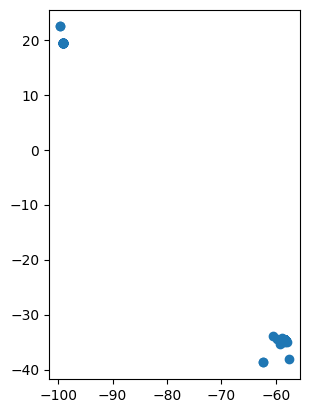

In [47]:
gdf.plot()

<Axes: >

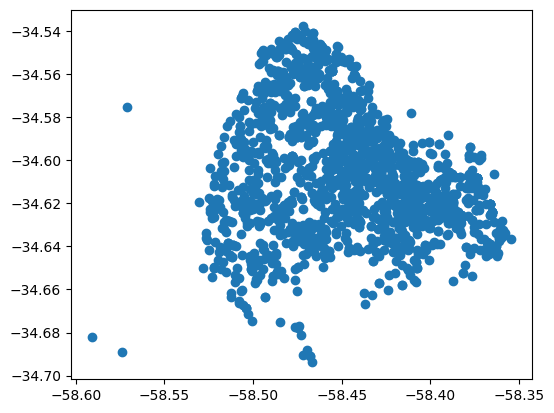

In [46]:
gdf.loc[(gdf.lng>-58.6)&(gdf.lat>-34.8)].plot()

El proceso de geocodificacion trae más información que nos podría servir para validar los resultados. Un proceso de validacion podria implementarse a partir de verificar la correspondencia con el barrio/comuna, etc. (no lo hacemos aqui).

In [50]:
terrenos.iloc[0]

DIRECCION          RIVADAVIA 3500
PROPIEDADS                    190
PRECIOUSD                  150000
PRECIOPESO               12000000
DOLARM2                       790
PESOSM2                     63158
COTIZACION                     80
TRIMESTRE_                 CUARTO
BARRIO                    ALMAGRO
COMUNA_                         5
Contiene_altura              True
lat                      -34.6109
lng                      -58.4157
Name: 0, dtype: object

In [56]:
resultsdict[0].geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'Avenida Rivadavia 3500, Almagro, Ciudad de Buenos Aires, C1203, Ciudad Autónoma de Buenos Aires',
    'bbox': [-58.416699991591,
     -34.611900010267,
     -58.414699991591,
     -34.609900010267],
    'confidence': 9,
    'lat': -34.61090001026676,
    'lng': -58.41569999159114,
    'ok': True,
    'quality': 'PointAddress',
    'raw': {'name': 'Avenida Rivadavia 3500, Almagro, Ciudad de Buenos Aires, C1203, Ciudad Autónoma de Buenos Aires',
     'extent': {'xmin': -58.416699991591,
      'ymin': -34.611900010267,
      'xmax': -58.414699991591,
      'ymax': -34.609900010267},
     'feature': {'geometry': {'x': -58.41569999159114,
       'y': -34.61090001026676},
      'attributes': {'Score': 98.21, 'Addr_Type': 'PointAddress'}}},
    'score': 98.21,
    'status': 'OK'},
   'bbox': [-58.416699991591,
    -34.611900010267,
    -58.414699991591,
    -34.609900010267],
   'geometry': {'type': 